Agenda
- K-means聚类
- 向量量化压缩图片 vector quantization
- 均值漂移聚类 mean shift
- 凝聚层次聚类 agglomerative clustering
- 聚类算法评价指标
- DBSCAN自动估算聚类数量
- 探索股票数据的模式
- 建立客户细分模型

#### K-means聚类算法
- 需指定聚类簇的数量
- http://www.onmyphd.com/?p=k-means.clustering&ckattempt=1

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans

In [0]:
# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_multivar_kmeans.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

   col_0  col_1
0   1.96  -0.09
1   2.84   3.16
2   4.74   1.84
3   6.36   4.89
4   1.77   1.55


Out[15]: Text(0.5, 1.0, 'Input data')

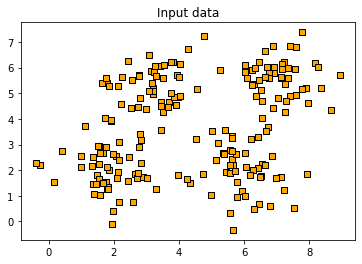

In [0]:
# 先对数据进行可视化，观察不同类别的分布情况
expand_df

xasix = expand_df.iloc[:,0].tolist()
yasix = expand_df.iloc[:,1].tolist()

plt.figure()
plt.scatter(xasix, yasix, facecolors='orange', edgecolors='black', marker='s')
# plt.scatter(class_1[:,0], class_1[:,1], facecolors='red', edgecolors='black', marker='s')
plt.title('Input data')

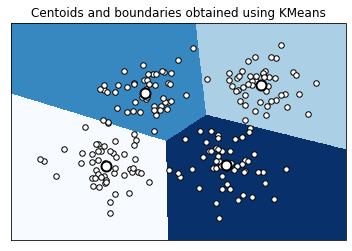

In [0]:
data = np.array(expand_df)

# 定义聚类簇数量
num_clusters = 4

# Train the model
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
kmeans.fit(data)

# 定义网格划分的颗粒度
step_size = 0.01

# Plot the boundaries
x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
x_values, y_values = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

# Predict labels for all points in the mesh
predicted_labels = kmeans.predict(np.c_[x_values.ravel(), y_values.ravel()])

# Plot the results
predicted_labels = predicted_labels.reshape(x_values.shape)
plt.figure()
plt.clf()
plt.imshow(predicted_labels, interpolation='nearest',
           extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

plt.scatter(data[:,0], data[:,1], marker='o', 
        facecolors='white', edgecolors='k', s=30)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], marker='o', s=100, linewidths=2,
        color='k', zorder=10, facecolors='white')
x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
plt.title('Centoids and boundaries obtained using KMeans')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#### 用矢量量化技术 - 压缩图片
- 可以简单理解为，对一维数组做四舍五入的N维版本拓展
- 把图片+每个像素被压缩的比特数作为输入定义
- 矢量量化被广泛用于图片压缩的场景中
- http://www.data-compression.com/vq.shtml

In [0]:
import argparse # argparse是python用于解析命令行参数和选项的标准模块
import numpy as np
from scipy import misc 
from sklearn import cluster
import matplotlib.pyplot as plt

In [0]:
# 创建一个函数来解析输入参数. 需要将图片和每个像素被压缩的比特数传入作为输入参数.
def build_arg_parser():
    parser = argparse.ArgumentParser(description='Compress the input image using clustering')
    parser.add_argument("--input-file", dest="input_file", required=True, help="Input image")
    parser.add_argument("--num-bits", dest="num_bits", required=False, type=int, help="Number of bits used to represent each pixel")
    return parser

In [0]:
# 定义图片压缩函数
def compress_image(img, num_clusters):
    # Convert input image into (num_samples, num_features) 
    # array to run kmeans clustering algorithm 
    X = img.reshape((-1, 1))  

    # Run kmeans on input data
    kmeans = cluster.KMeans(n_clusters=num_clusters, n_init=4, random_state=5)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_.squeeze()
    labels = kmeans.labels_

    # Assign each value to the nearest centroid and 
    # reshape it to the original image shape
    input_image_compressed = np.choose(labels, centroids).reshape(img.shape)

    return input_image_compressed


# 可视化压缩算法对图片的影响, 将结果输出
def plot_image(img, title):
    vmin = img.min()
    vmax = img.max()
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

In [0]:
if __name__=='__main__':
    args = build_arg_parser().parse_args()
    input_file = args.input_file
    num_bits = args.num_bits

    if not 1 <= num_bits <= 8:
        raise TypeError('Number of bits should be between 1 and 8')

    num_clusters = np.power(2, num_bits)

    # Print compression rate
    compression_rate = round(100 * (8.0 - args.num_bits) / 8.0, 2)
    print("\nThe size of the image will be reduced by a factor of", 8.0/args.num_bits)
    print("\nCompression rate = " + str(compression_rate) + "%")

    # Load input image
    input_image = misc.imread(input_file, True).astype(np.uint8)

    # original image 
    plot_image(input_image, 'Original image')

    # compressed image 
    input_image_compressed = compress_image(input_image, num_clusters)
    plot_image(input_image_compressed, 'Compressed image; compression rate = ' 
            + str(compression_rate) + '%')

    plt.show()
    

# 在jupyter中直接运行会报错,因为调用parser.parse_args()会读取系统参数
# 官方运行程序的方法为在python的命令行环境中调用, 将如上所有的程序保存为.py文件,命名vector_quantization.py
# 命令行调用方式: $python vector_quantization.py --input-file flower_image.jpg --num-bits 2

usage: db_ipykernel_launcher.py [-h] --input-file INPUT_FILE
                                [--num-bits NUM_BITS]
db_ipykernel_launcher.py: error: the following arguments are required: --input-file


An exception has occurred, use %tb to see the full traceback.

SystemExit: 2


#### 均值漂移聚类模型 (Mean shifting)
- 不需要指定聚类簇的数量
- 算法将点的分布看成概率密度函数(probability-density function), 根据概率分布特征找到聚类中心和模式. 假设某些点有聚类聚集,那么他们很可能对应概率密度函数的峰值
- https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/TUZEL1/MeanShift.pdf

In [0]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth

In [0]:
# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_multivar_kmeans.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

   col_0  col_1
0   1.96  -0.09
1   2.84   3.16
2   4.74   1.84
3   6.36   4.89
4   1.77   1.55


In [0]:
X = np.array(expand_df)

# 通过指定参数创建均值漂移模型
# Estimating the bandwidth 
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=len(X))

# Compute clustering with MeanShift
meanshift_estimator = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift_estimator.fit(X)
labels = meanshift_estimator.labels_
centroids = meanshift_estimator.cluster_centers_
num_clusters = len(np.unique(labels))

# 输出聚类簇的数量
print("Number of clusters in input data =", num_clusters)

Number of clusters in input data = 4


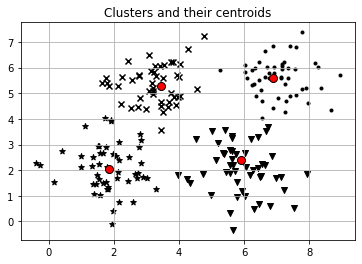

In [0]:
# Plot the points and centroids 

import matplotlib.pyplot as plt
from itertools import cycle

plt.figure()

# specify marker shapes for different clusters. 为每种聚类簇设置不同的标记
markers = '.*xv'

for i, marker in zip(range(num_clusters), markers):
    # plot the points belong to the current cluster
    plt.scatter(X[labels==i, 0], X[labels==i, 1], marker=marker, color='k')

    # plot the centroid of the current cluster
    centroid = centroids[i]
    plt.plot(centroid[0], centroid[1], marker='o', markerfacecolor='red5', markeredgecolor='k', markersize=8)

plt.grid()
plt.title('Clusters and their centroids')
plt.show()

#### 凝聚层次聚类(Hierarchical Clustering)
- 是一组聚类算法,通过不断地分解和合并聚类结构来构建树状聚类簇
- https://nlp.stanford.edu/IR-book/html/htmledition/hierarchical-agglomerative-clustering-1.html

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [0]:
# 增加噪声来体现不确定性
def add_noise(x, y, amplitude):
    X = np.concatenate((x, y))
    X += amplitude * np.random.randn(2, X.shape[1])
    return X.T

# 定义函数生成螺旋状的数据点分布,来体现层次聚类的优势. 可实现对空间上连在一起,而不是距离很近的点进行聚类
def get_spiral(t, noise_amplitude=0.5):
    r = t
    x = r * np.cos(t)
    y = r * np.sin(t)

    return add_noise(x, y, noise_amplitude)

# 定义函数来获取玫瑰曲线上的数据点(rose_curve, rhodonea_curve. 极坐标中的正弦曲线)
def get_rose(t, noise_amplitude=0.02):
    # Equation for "rose" (or rhodonea curve); if k is odd, then
    # the curve will have k petals, else it will have 2k petals
    k = 5       
    r = np.cos(k*t) + 0.25 
    x = r * np.cos(t)
    y = r * np.sin(t)

    return add_noise(x, y, noise_amplitude)

# 增加数据多样性
def get_hypotrochoid(t, noise_amplitude=0):
    a, b, h = 10.0, 2.0, 4.0
    x = (a - b) * np.cos(t) + h * np.cos((a - b) / b * t) 
    y = (a - b) * np.sin(t) - h * np.sin((a - b) / b * t) 

    return add_noise(x, y, 0)

# 定义实现层次聚类的函数
def perform_clustering(X, connectivity, title, num_clusters=3, linkage='ward'):
    plt.figure()
    model = AgglomerativeClustering(linkage=linkage, 
                    connectivity=connectivity, n_clusters=num_clusters)
    model.fit(X)

    # extract labels
    labels = model.labels_

    # specify marker shapes for different clusters. 用不同标记显示不同类别
    markers = '.vx'

    for i, marker in zip(range(num_clusters), markers):
        # plot the points belong to the current cluster
        plt.scatter(X[labels==i, 0], X[labels==i, 1], s=50, 
                    marker=marker, color='k', facecolors='orange')

    plt.title(title)

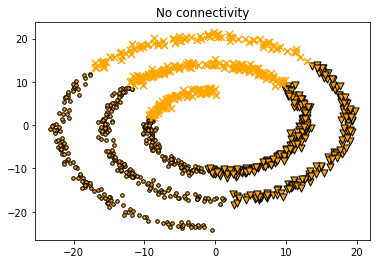

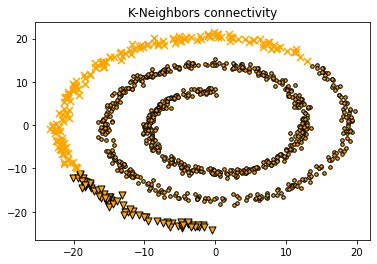

In [0]:
# Generate sample data
n_samples = 1000
np.random.seed(2)
t = 2.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))

X = get_spiral(t)
# X = get_rose(t)
# X = get_hypotrochoid(t)

# No connectivity
connectivity = None 
perform_clustering(X, connectivity, 'No connectivity')

# Create K-Neighbors graph 
connectivity = kneighbors_graph(X, 10, include_self=False)
perform_clustering(X, connectivity, 'K-Neighbors connectivity')

plt.show()

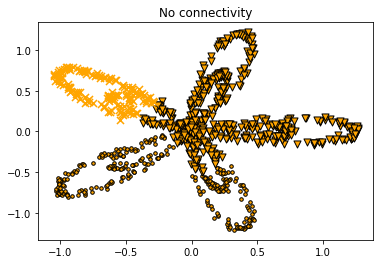

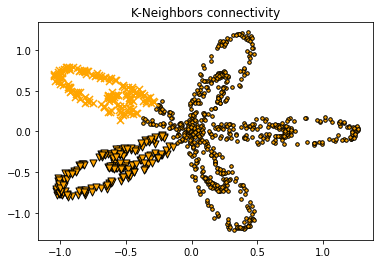

In [0]:
# Generate sample data
n_samples = 1000
np.random.seed(2)
t = 2.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))

# X = get_spiral(t)
X = get_rose(t)
# X = get_hypotrochoid(t)

# No connectivity
connectivity = None 
perform_clustering(X, connectivity, 'No connectivity')

# Create K-Neighbors graph 
connectivity = kneighbors_graph(X, 10, include_self=False)
perform_clustering(X, connectivity, 'K-Neighbors connectivity')

plt.show()

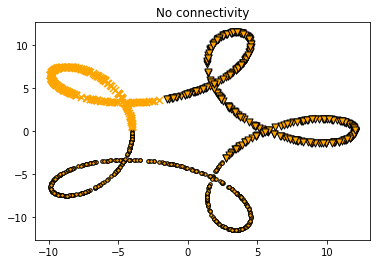

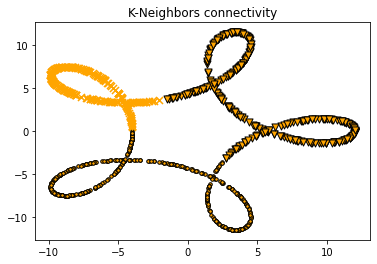

In [0]:
# Generate sample data
n_samples = 1000
np.random.seed(2)
t = 2.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))

# X = get_spiral(t)
# X = get_rose(t)
X = get_hypotrochoid(t)

# No connectivity
connectivity = None 
perform_clustering(X, connectivity, 'No connectivity')

# Create K-Neighbors graph 
connectivity = kneighbors_graph(X, 10, include_self=False)
perform_clustering(X, connectivity, 'K-Neighbors connectivity')

plt.show()

#### 聚类算法的效果评估
- 判断一个聚类簇中的点是不是足够紧密
- 用轮廓系数来衡量(Silhouette Coefficient), 该得分是为每个数据点来定义的. score = (x-y)/max(x,y)
  - x: 同一个聚类中,某个数据点与其他数据点的平均距离 - 样本与本簇中点的相似度
  - y: 某个数据点与最近的另一个聚类所有点的平均距离 - 样本与下一个簇中点的相似度
  - 轮廓系数score的取值范围(-1,1).s越接近于1,聚类效果越好; s越接近-1,聚类效果越差.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans

In [0]:
# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_perf.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

   col_0  col_1
0   1.65   1.91
1   2.77   4.98
2   5.82   2.56
3   7.24   5.24
4  -0.30   4.06


In [0]:
scores = []

# 定义不同聚类簇的数量取值范围
range_values = np.arange(2, 10)

for i in range_values:
    # Train the model
    kmeans = KMeans(init='k-means++', n_clusters=i, n_init=10)
    kmeans.fit(data)
    score = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean', sample_size=len(data))

    print("\nNumber of clusters =", i)
    print("Silhouette score =", score)
                    
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.44051515963779503

Number of clusters = 3
Silhouette score = 0.4831677263389899

Number of clusters = 4
Silhouette score = 0.5773232071896658

Number of clusters = 5
Silhouette score = 0.5198624907789864

Number of clusters = 6
Silhouette score = 0.4454746563823243

Number of clusters = 7
Silhouette score = 0.39788108595371824

Number of clusters = 8
Silhouette score = 0.32759674848603604

Number of clusters = 9
Silhouette score = 0.3545865679792736


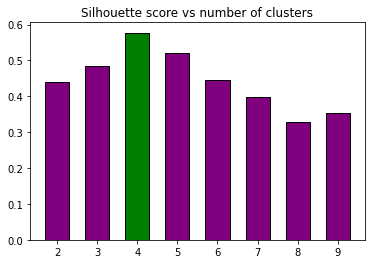

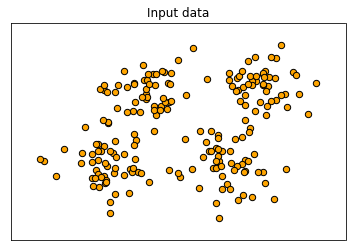

In [0]:
# Plot scores
plt.figure()
plt.bar(range_values, scores, width=0.6, facecolor='purple', edgecolor='black', align='center')
plt.bar(range_values[np.argmax(scores)], max(scores), width=0.6, facecolor='green', edgecolor='black', align='center')
# np.argmax(scores) - array输出最大值对应的索引值
plt.title('Silhouette score vs number of clusters')

# Plot data
plt.figure()
plt.scatter(data[:,0], data[:,1], color='k', s=40, marker='o', facecolors='orange')
x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
plt.title('Input data')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

#### BDSCAN - 带噪声基于密度的聚类方法
- https://weber.itn.liu.se/~aidvi/courses/06/dm/Seminars2011/DBSCAN(4).pdf
- 不需要定义聚类数量n
- 定义eplison来控制一个点到其他点的最大距离,借此可以用来处理异常值点

In [0]:
from itertools import cycle
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt

In [0]:
# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_perf.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

   col_0  col_1
0   1.65   1.91
1   2.77   4.98
2   5.82   2.56
3   7.24   5.24
4  -0.30   4.06


In [0]:
X = np.array(expand_df)

# Find the best epsilon , 为了找到最佳聚类数量，先初始化一些变量
eps_grid = np.linspace(0.3, 1.2, num=10)
silhouette_scores = []
eps_best = eps_grid[0]
silhouette_score_max = -1
model_best = None
labels_best = None

for eps in eps_grid:
    # Train DBSCAN clustering model
    model = DBSCAN(eps=eps, min_samples=5).fit(X)

    # Extract labels
    labels = model.labels_

    # Extract performance metric 
    silhouette_score = round(metrics.silhouette_score(X, labels), 4)
    silhouette_scores.append(silhouette_score)

    print("Epsilon:", round(eps,1), " --> silhouette score:", silhouette_score)

    if silhouette_score > silhouette_score_max:
        silhouette_score_max = silhouette_score
        eps_best = eps
        model_best = model
        labels_best = labels

Epsilon: 0.3  --> silhouette score: 0.1287
Epsilon: 0.4  --> silhouette score: 0.3594
Epsilon: 0.5  --> silhouette score: 0.5134
Epsilon: 0.6  --> silhouette score: 0.6165
Epsilon: 0.7  --> silhouette score: 0.6322
Epsilon: 0.8  --> silhouette score: 0.6366
Epsilon: 0.9  --> silhouette score: 0.5142
Epsilon: 1.0  --> silhouette score: 0.5629
Epsilon: 1.1  --> silhouette score: 0.5629
Epsilon: 1.2  --> silhouette score: 0.5629



Best epsilon = 0.8


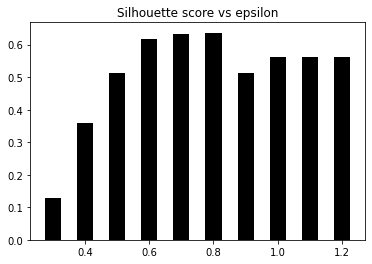

In [0]:
# Plot silhouette scores vs epsilon
plt.figure()
plt.bar(eps_grid, silhouette_scores, width=0.05, color='k', align='center')
plt.title('Silhouette score vs epsilon')

# Best params
print("\nBest epsilon =", round(eps_best,1))


Estimated number of clusters = 5
<command-3019780221987470>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_core = np.zeros(labels.shape, dtype=np.bool)
<command-3019780221987470>:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
<command-3019780221987470>:37: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt

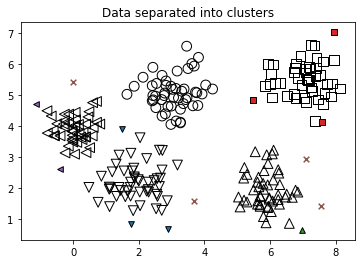

In [0]:
# Associated model and labels for best epsilon, 关联最优模型和标签
model = model_best 
labels = labels_best

# Check for unassigned datapoints in the labels，提取没有被分到聚类簇中的点，需要识别并排除
offset = 0
if -1 in labels:
    offset = 1

# Number of clusters in the data，提取聚类的数量
num_clusters = len(set(labels)) - offset 

print("\nEstimated number of clusters =", num_clusters)


# Extracts the core samples from the trained model，从训练模型中提取核心样本的数据点索引
mask_core = np.zeros(labels.shape, dtype=np.bool)
mask_core[model.core_sample_indices_] = True

# Plot resultant clusters - 用不同标记画出每个聚类的数据点
plt.figure()
labels_uniq = set(labels)
markers = cycle('vo^s<>')
for cur_label, marker in zip(labels_uniq, markers):
    # Use black dots for unassigned datapoints - 未分配簇的样本点
    if cur_label == -1:
        marker = 'x'

    # Create mask for the current label - 为当前标记添加符号
    cur_mask = (labels == cur_label)

    cur_data = X[cur_mask & mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
             edgecolors='black', s=96, facecolors='none')

    cur_data = X[cur_mask & ~mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
             edgecolors='black', s=32)

plt.title('Data separated into clusters')
plt.show()

#### 探索股票数据的模式
- 近邻传播聚类算法/Affinity Propagation
- 通过取样器(examplar), 找到每个聚类中具有代表性的数据点，并找到数据点间的相似性度量值，并把所有的数据点看作潜在的代表性数据点
- http://www.cs.columbia.edu/~delbert/docs/DDueck-thesis_small.pdf

In [0]:
# import json
# import datetime

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import covariance, cluster
# from matplotlib.finance import quotes_historical_yahoo_ochl as quotes_yahoo

# # Input symbol file - 包含符号和对应的名称
# symbol_file = 'symbol_map.json'

# # Choose a time period
# start_date = datetime.datetime(2004, 4, 5)
# end_date = datetime.datetime(2007, 6, 2)

# # Load the symbol map - 从符号映射文件中读取数据
# with open(symbol_file, 'r') as f:
#     symbol_dict = json.loads(f.read())

# symbols, names = np.array(list(symbol_dict.items())).T

# quotes = [quotes_yahoo(symbol, start_date, end_date, asobject=True) 
#                 for symbol in symbols]

# # Extract opening and closing quotes - 提取开盘价和收盘价
# opening_quotes = np.array([quote.open for quote in quotes]).astype(np.float)
# closing_quotes = np.array([quote.close for quote in quotes]).astype(np.float)

# # The daily fluctuations of the quotes 每日股价波动
# delta_quotes = closing_quotes - opening_quotes

# # Build a graph model from the correlations 建立协方差图模型
# edge_model = covariance.GraphLassoCV()

# # Standardize the data 
# X = delta_quotes.copy().T
# X /= X.std(axis=0)

# # Train the model
# with np.errstate(invalid='ignore'):
#     edge_model.fit(X)

# # Build clustering model using affinity propagation
# _, labels = cluster.affinity_propagation(edge_model.covariance_)
# num_labels = labels.max()

# # Print the results of clustering
# for i in range(num_labels + 1):
#     print("Cluster", i+1, "-->", ', '.join(names[labels == i]))

# # 根据提取的特性，将不同股票分到了不同组别中

#### 建立客户细分模型
- 无监督学习在市场细分中的应用。市场细分对广告投放，库存管理，配送策略中起到了重要作用
- 多特征(>2)通过均值漂移聚类，得到不同聚类簇
- 数据源：https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

In [0]:
import numpy as np
import pandas as pd
from sklearn import cluster, covariance, manifold
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

In [0]:
df = spark.read.csv('/FileStore/tables/wholesale.csv', header="true", inferSchema="true")
expand_df = df.toPandas()
expand_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125



Number of clusters in input data = 8

Centroids of clusters:
Fres	Milk	Groc	Froz	Dete	Deli
9632	4671	6593	2570	2296	1248
40204	46314	57584	5518	25436	4241
112151	29627	18148	16745	4948	8550
36847	43950	20170	36534	239	47943
32717	16784	13626	60869	1272	5609
22925	73498	32114	987	20070	903
16117	46197	92780	1026	40827	2944
8565	4980	67298	131	38102	1215


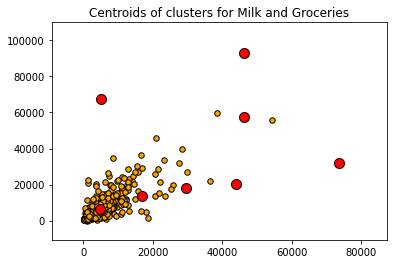

In [0]:
# 取特征列名
names = expand_df.columns[2:]
# 取特征对应值
X = np.array(expand_df.iloc[:,2:])

# Estimating the bandwidth 
bandwidth = estimate_bandwidth(X, quantile=0.8, n_samples=len(X))

# Compute clustering with MeanShift
meanshift_estimator = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift_estimator.fit(X)
labels = meanshift_estimator.labels_
centroids = meanshift_estimator.cluster_centers_
num_clusters = len(np.unique(labels))

print ("\nNumber of clusters in input data =", num_clusters)

print ("\nCentroids of clusters:")
print ('\t'.join([name[:4] for name in names]))
for centroid in centroids:
    print ('\t'.join([str(int(x)) for x in centroid]))

################
# Visualizing data
# Plot the nodes using the coordinates of our centroids_milk_groceries - 描绘milk和grocery两个特征的聚类中心。
# 同理，可以展示显示其他任意两个特征的聚类中心结果

X_milk_groceries = X[:, 1:3]
centroids_milk_groceries = centroids[:, 1:3]

plt.figure()

plt.scatter(X_milk_groceries[:,0], X_milk_groceries[:,1], 
        s=30, edgecolors='k', facecolors='orange')
plt.scatter(centroids_milk_groceries[:,0], centroids_milk_groceries[:,1], 
        s=100, edgecolors='k', facecolors='red')

offset = 0.2
plt.xlim(centroids_milk_groceries[:,0].min() - offset * centroids_milk_groceries[:,0].ptp(),
        centroids_milk_groceries[:,0].max() + offset * centroids_milk_groceries[:,0].ptp(),)
plt.ylim(centroids_milk_groceries[:,1].min() - offset * centroids_milk_groceries[:,1].ptp(),
        centroids_milk_groceries[:,1].max() + offset * centroids_milk_groceries[:,1].ptp())

plt.title('Centroids of clusters for Milk and Groceries')
plt.show()